In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Airline Passengers

In [2]:
df1 = pd.read_excel("Airline Passengers.xlsx")
df1['Month'] = pd.to_datetime(df1['Month'], format="%Y-%m")
df1.set_index("Month", inplace=True)
df1.sort_index()
print("Min Date",df1.index.min())
print("Max Date", df1.index.max())
print(df1.info())
df1.head()

Min Date 2015-01-01 00:00:00
Max Date 2019-12-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes
None


,Passengers
Month,
2015-01-01,1120
2015-02-01,1180
2015-03-01,1320
2015-04-01,1450
2015-05-01,1600


In [3]:
def split_sets(df, test_size=4, val_size=8):
    test_set = df[-test_size:]             
    val_set = df[-(test_size + val_size):-test_size] 
    train_set = df[:-(test_size + val_size)]
    return train_set.asfreq('MS'), val_set.asfreq('MS'), test_set.asfreq('MS')

train, val, test = split_sets(df1)

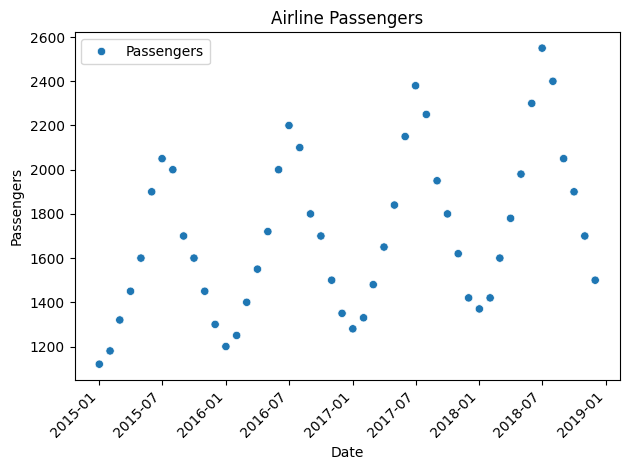

In [4]:
sns.scatterplot(data=train)
plt.title("Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

There's a clear upward trend going on. It's stable so we can say that the trend component is additive. Although its not as obvious as the seasonality.

Seasonality exist every year with peak of passengers around the middle of the year (most likely summer) and then goes back down at each ends of the year.

Minimal randomness can be found.

Looking at this simple line plot, it appears the seasonality is **multiplicative**. This is evident with increase in the magnitude of fluctuation as trend increases.

Since there is a clear trend and multiplicative seasonality (period=12 or yearly), we will choose a Holt-Winters Multiplicative Model. Needless to say, the said model takes into account all that we need in Airline Passengers dataset.

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [6]:
model = ExponentialSmoothing(
    train['Passengers'],
    trend='add',
    seasonal='mul', 
    seasonal_periods=12  
).fit()

model.summary()

Dep. Variable:,Passengers,No. Observations:,48
Model:,ExponentialSmoothing,SSE,9391.857
Optimized:,True,AIC,285.267
Trend:,Additive,BIC,315.206
Seasonal:,Multiplicative,AICC,308.853
Seasonal Periods:,12,Date:,"Tue, 23 Sep 2025"
Box-Cox:,False,Time:,23:15:53
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4881576,alpha,True
smoothing_trend,0.000000,beta,True


1. Alpha = 0.488 (Level Smoothing) - With an alpha level of around 50%, the model deem it best to have the recent data and historical data have equal weights. This imply a moderate volatility so the smoothing is not too smooth and not too reactive.

2. Beta = 0.000 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

3. Gamma = 0.000 (Seasonal Smoothing) - seonality is another stable component that does not change overtime.

Overall the model indicates minimal volatilitily and the amount of passengers remain stable as time goes by.

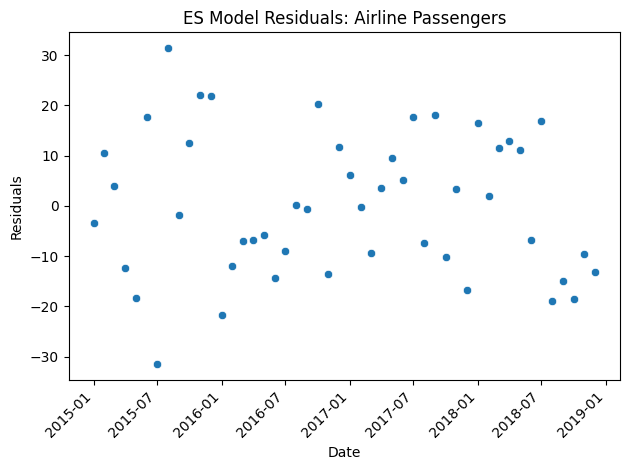

In [7]:
sns.scatterplot(data=model.resid)
plt.title("ES Model Residuals: Airline Passengers")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Residuals looks random.

In [8]:
def progressive_validation(train_set, val_set, forecast_horizon=4):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    
    results = []
    
    # Maximum number of steps we can take
    n_steps = len(val_set) - forecast_horizon + 1
    
    
    for step in range(n_steps):
        # Expand training set by 'step' periods
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        # Test window slides by 1 each time
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        # Skip if not enough data
        if len(test_window) < forecast_horizon:
            break
        
        # Fit model
        model = ExponentialSmoothing(
            current_train,
            trend='add',
            seasonal='mul',
            seasonal_periods=12
        ).fit()
        
        # Forecast
        forecast = model.forecast(steps=forecast_horizon)
        
        # Calculate metrics
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
        
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE:")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

# Run it
prog_results = progressive_validation(train, val, forecast_horizon=4)
prog_results

AVERAGE PERFORMANCE:
MAPE: 13.41% (+- 2.41%)
MAD:  272.19 (+- 66.64)
MSD:  121785.64 (+- 56047.82)


,step,train_size,MAPE,MAD,MSD,test_period
0,1,48,11.328857,186.594180,55557.747073,2019-01 to 2019-04
1,2,49,13.862951,246.242824,94304.166380,2019-02 to 2019-05
2,3,50,15.508246,314.571978,156251.091891,2019-03 to 2019-06
3,4,51,15.847865,359.574617,198742.988421,2019-04 to 2019-07
4,5,52,10.517825,253.985547,104072.219768,2019-05 to 2019-08


Basically the function is a walk forward validation. Here are the process:
1. Train a model from original current training set
2. Forecast upto given forecast horizon.
3. Calculate the (accuracy metrics)/forecast horizon
4. Add another actual data point to the current training set.
5. Go back to step 1 (until remaining data points cannot accomodate for forecast horizon)

MAPE: 13.99%
MAE: 258.06
STD ERROR: 554.2434213116513


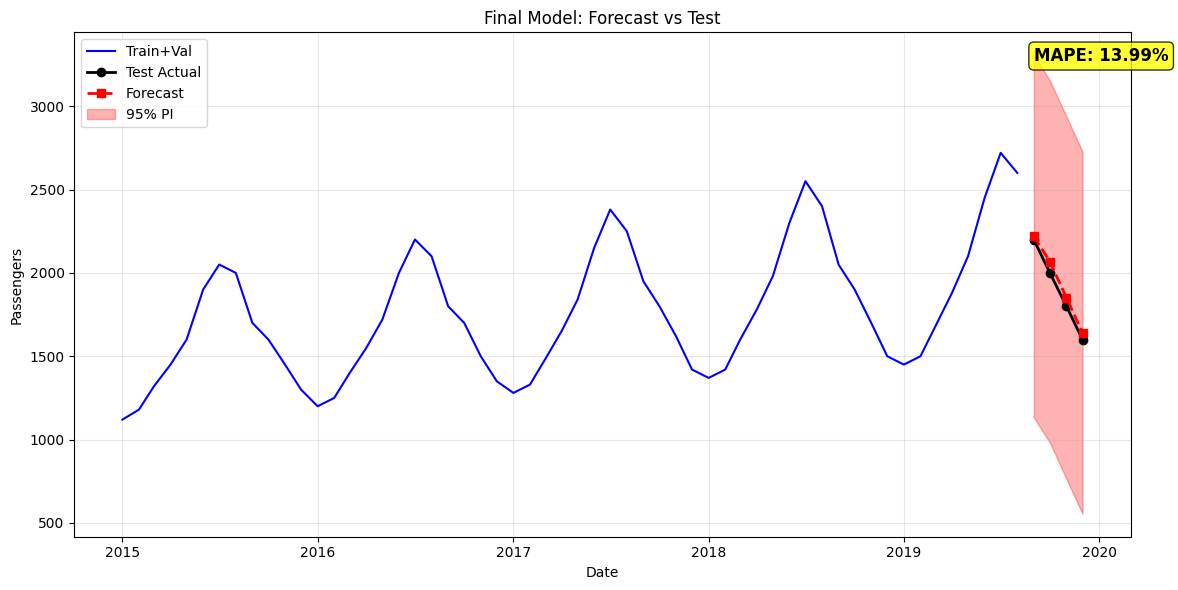

In [9]:
def final_model_evaluation(train_set, val_set, test_set):
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        train_val = pd.concat([train_set, val_set])

        model = ExponentialSmoothing(
        train_val,
        trend='add',
        seasonal='mul',
        seasonal_periods=12
        ).fit()

        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100


        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])  # Remove NaN values

        lower_bound = forecast.values - 1.96 * std_error
        upper_bound = forecast.values + 1.96 * std_error

        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")
        plt.figure(figsize=(12, 6))

        # Plot historical data
        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        # Plot test actual and forecast
        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        # Plot prediction intervals
        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        # Add MAPE annotation
        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title('Final Model: Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train, val, test)

---

## CPI

In [10]:
df2 = pd.read_excel("CPI.xlsx")

df2['Year'] = df2['Quarter'].str.split('-').str[0].astype(int)
df2['Q'] = df2['Quarter'].str.split('-').str[1].str[1].astype(int)

df2['Date'] = pd.PeriodIndex(year=df2['Year'], quarter=df2['Q'], freq='Q').to_timestamp()
df2.set_index('Date', inplace=True)

df2 = df2.drop(['Year', 'Q', 'Quarter'], axis=1)

df2.sort_index(inplace=True)
print("Min Date",df2.index.min())
print("Max Date", df2.index.max())

Min Date 2010-01-01 00:00:00
Max Date 2019-10-01 00:00:00


D:\tmp\ipykernel_6252\3991139837.py:6: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df2['Date'] = pd.PeriodIndex(year=df2['Year'], quarter=df2['Q'], freq='Q').to_timestamp()


In [11]:
def split_sets(df, test_size=4, val_size=8):
    test_set = df[-test_size:]             
    val_set = df[-(test_size + val_size):-test_size] 
    train_set = df[:-(test_size + val_size)]
    return train_set.asfreq('MS'), val_set.asfreq('MS'), test_set.asfreq('MS')

train, val, test = split_sets(df2)

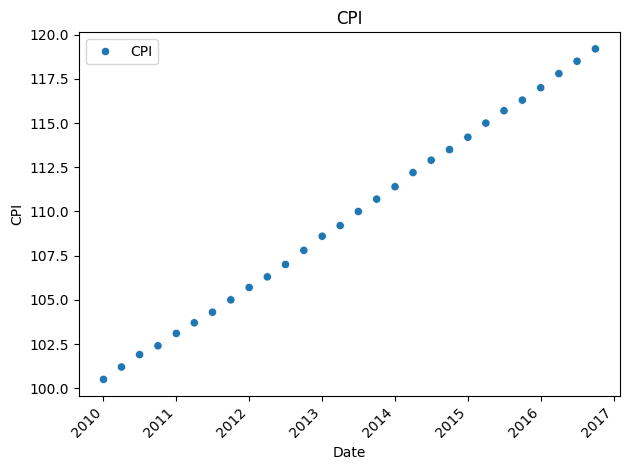

In [12]:
sns.scatterplot(data=train)
plt.title("CPI")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

- There is a clear linear trend going on.
- Sesonality on the other hand does not exists.
- No randomness can be found.

For this one, we can just use Double Exponential Smoothing (Holt's Method) that accounts for both level ($\alpha$) and trend ($\beta$).

In [13]:
from statsmodels.tsa.holtwinters import Holt

train_nona = train.squeeze().dropna()
model = Holt(train_nona.values).fit(optimized=True)
model.summary()

Dep. Variable:,endog,No. Observations:,28
Model:,Holt,SSE,0.650
Optimized:,True,AIC,-97.379
Trend:,Additive,BIC,-92.051
Seasonal:,None,AICC,-93.379
Seasonal Periods:,None,Date:,"Tue, 23 Sep 2025"
Box-Cox:,False,Time:,23:15:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9939685,alpha,True
smoothing_trend,0.0049059,beta,True


1. Alpha = 	0.993 (Level Smoothing) - With a alpha level of almost 1, smoothed series is equals to the original data. Which means the model is giving very high weight to recent observations and very little to historical values.

2. Beta = 0.004 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

The model parameters tell us that the best way to forecast is to start with the most recent value and add a fairly constant rate of increase.

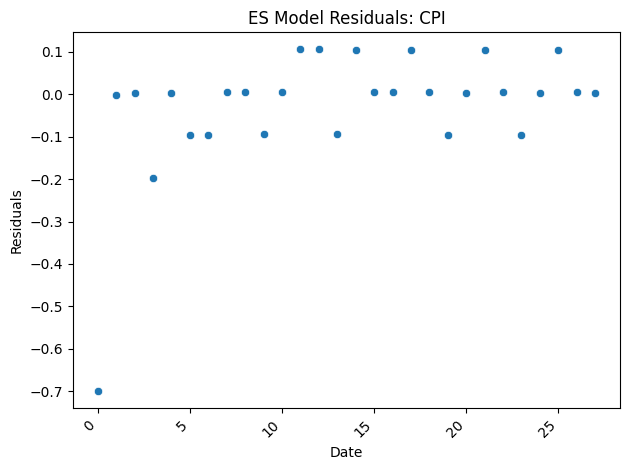

In [14]:
sns.scatterplot(data=model.resid)
plt.title("ES Model Residuals: CPI")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

There is one outlier but the data seem to hover around 0 randomly. Some are even practically 0 which make sense given the $\alpha \approx 1$ 

In [16]:
def progressive_validation(train_set, val_set, forecast_horizon=4):    
    results = []
    
    # Maximum number of steps we can take
    n_steps = len(val_set) - forecast_horizon + 1
    
    
    for step in range(n_steps):
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        # Test window slides by 1 each time
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        # Skip if not enough data
        if len(test_window) < forecast_horizon:
            break
        

        model = Holt(current_train).fit(optimized=True)

        
        # Forecast
        forecast = model.forecast(steps=forecast_horizon)
        
        # Calculate metrics
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
        
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE:")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

# Run it
prog_results = progressive_validation(train.dropna(), val.dropna(), forecast_horizon=4)
prog_results

AVERAGE PERFORMANCE:
MAPE: 0.76% (+- 0.02%)
MAD:  0.93 (+- 0.01)
MSD:  1.31 (+- 0.02)


,step,train_size,MAPE,MAD,MSD,test_period
0,1,28,0.773627,0.937506,1.316294,2017-01 to 2017-10
1,2,29,0.769016,0.937500,1.345000,2017-04 to 2018-01
2,3,30,0.764198,0.937500,1.320000,2017-07 to 2018-04
3,4,31,0.739774,0.912500,1.285000,2017-10 to 2018-07
4,5,32,0.745047,0.925000,1.295000,2018-01 to 2018-10


In [24]:
model.summary()

Dep. Variable:,CPI,No. Observations:,36
Model:,Holt,SSE,0.690
Optimized:,True,AIC,-134.365
Trend:,Additive,BIC,-128.031
Seasonal:,None,AICC,-131.468
Seasonal Periods:,None,Date:,"Tue, 23 Sep 2025"
Box-Cox:,False,Time:,23:21:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


MAPE: 0.69%
MAE: 0.88
STD ERROR: 10.367327223223368


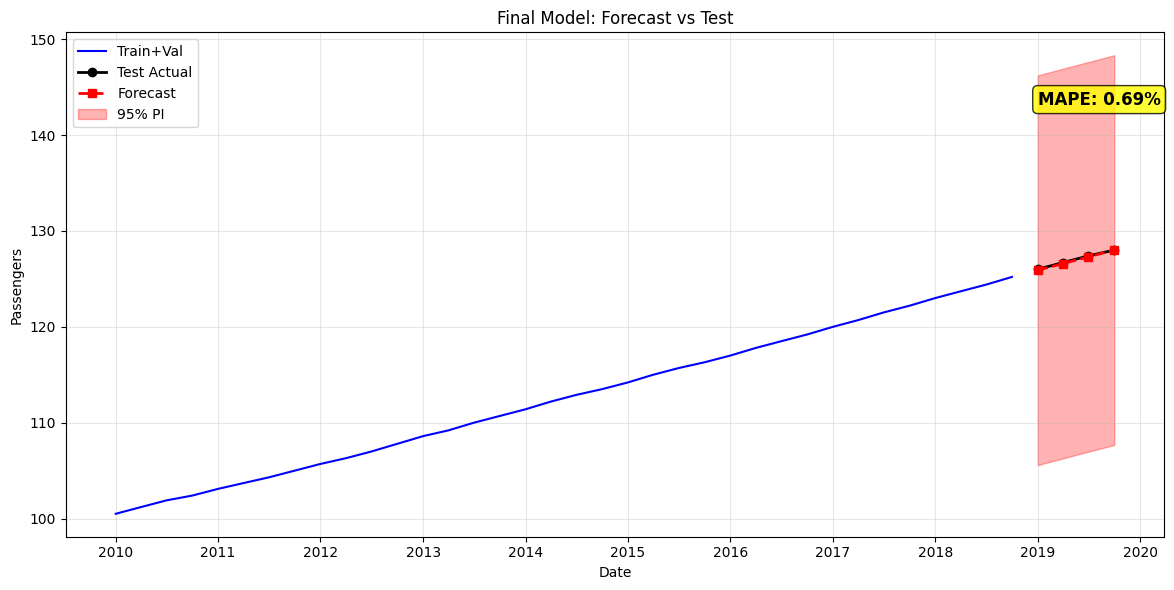

In [26]:
def final_model_evaluation(train_set, val_set, test_set):
        train_val = pd.concat([train_set, val_set])

        model = Holt(train_val).fit(optimized=True)


        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100

        
        # calculate std of residuals
        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])

        lower_bound = forecast.values - 1.96 * std_error
        upper_bound = forecast.values + 1.96 * std_error

        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")
        plt.figure(figsize=(12, 6))

        # Plot historical data
        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        # Plot test actual and forecast
        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        # Plot prediction intervals
        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        # Add MAPE annotation
        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title('Final Model: Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train.dropna(), val.dropna(), test.dropna())

---

## Ice Cream Sales

In [35]:
df3 = pd.read_excel("Ice Cream Sales.xlsx")
df3['Month'] = pd.to_datetime(df3['Month'], format="%Y-%m")
df3.set_index("Month", inplace=True)
df3.sort_index()
print("Min Date",df3.index.min())
print("Max Date", df3.index.max())
print(df3.info())
df3.head()

Min Date 2015-01-01 00:00:00
Max Date 2019-12-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes
None


,Sales
Month,
2015-01-01,120
2015-02-01,118
2015-03-01,140
2015-04-01,150
2015-05-01,180


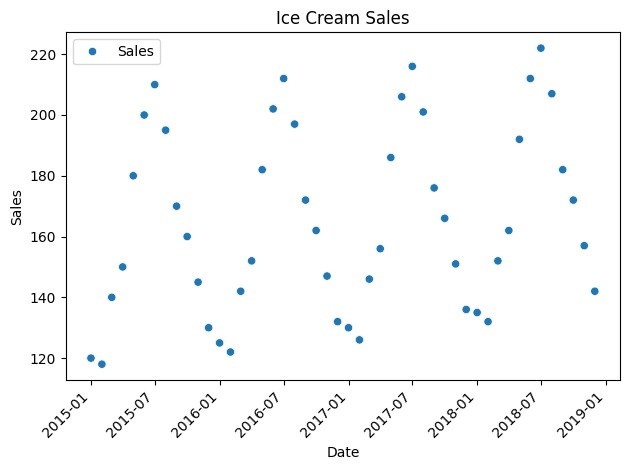

In [36]:
train, val, test = split_sets(df3)
sns.scatterplot(data=train)
plt.title("Ice Cream Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

This is simmilar to that of Airline Passengers with minimal randomness, trend (although minimal but stable; so additive) and sesonality but this time it is additive for its magnitude remains constant as time goes by. Therefore, instead of using Multiplicative Holts-Winter (period=12), we shall use its additive equivalent.

In [33]:
model = ExponentialSmoothing(
    train['Sales'],
    trend='add',
    seasonal='add', 
    seasonal_periods=12  
).fit()

model.summary()

Dep. Variable:,Sales,No. Observations:,48
Model:,ExponentialSmoothing,SSE,13.667
Optimized:,True,AIC,-28.300
Trend:,Additive,BIC,1.640
Seasonal:,Additive,AICC,-4.713
Seasonal Periods:,12,Date:,"Tue, 23 Sep 2025"
Box-Cox:,False,Time:,23:32:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


The coeficient for beta and Gamma too is simillar to the Airplane Passengers dataset but the Alpha is equals to 1.

1. Alpha = 0.488 (Level Smoothing) - With an alpha level of 1, the model gives 100% importance on the most recent values and gives no importance to the past values. This is essentially each forecast is the last observed value + trend + seasonal component.

2. Beta = 0.000 (Trend Smoothing) - This indicates that the trend is very stable and that the trend does not accelerate nor decelerate.

3. Gamma = 0.000 (Seasonal Smoothing) - seonality is another stable component that does not change overtime.

Overall, the ice cream sales model indicates that the sales have fixed seasonal and trend component and relies heavily/solely on the sales from the last month.

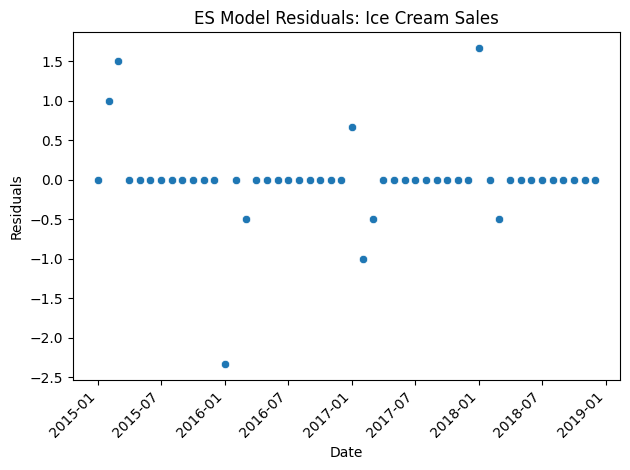

In [37]:
sns.scatterplot(data=model.resid)
plt.title("ES Model Residuals: Ice Cream Sales")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

Most are at 0 but there's no any apparent pattern left to discern.

In [38]:
def progressive_validation(train_set, val_set, forecast_horizon=4):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    
    results = []
    
    # Maximum number of steps we can take
    n_steps = len(val_set) - forecast_horizon + 1
    
    
    for step in range(n_steps):
        # Expand training set by 'step' periods
        if step == 0:
            current_train = train_set
        else:
            val_to_include = val_set[:step]
            current_train = pd.concat([train_set, val_to_include])
        
        # Test window slides by 1 each time
        test_start = step 
        test_end = test_start + forecast_horizon
        test_window = val_set[test_start:test_end]
        
        # Skip if not enough data
        if len(test_window) < forecast_horizon:
            break
        
        # Fit model
        model = ExponentialSmoothing(
            current_train,
            trend='add',
            seasonal='add',
            seasonal_periods=12
        ).fit()
        
        # Forecast
        forecast = model.forecast(steps=forecast_horizon)
        
        # Calculate metrics
        errors = test_window.values - forecast.values
        mape = np.mean(np.abs(errors / test_window.values)) * 100
        mad = np.mean(np.abs(errors))
        msd = np.mean(errors ** 2)
        
        results.append({
            'step': step + 1,
            'train_size': len(current_train),
            'MAPE': mape,
            'MAD': mad,
            'MSD': msd,
            'test_period': f"{test_window.index[0].strftime('%Y-%m')} to {test_window.index[-1].strftime('%Y-%m')}"
        })
        
    
    results_df = pd.DataFrame(results)
    
    print(f"AVERAGE PERFORMANCE:")
    print(f"MAPE: {results_df['MAPE'].mean():.2f}% (+- {results_df['MAPE'].std():.2f}%)")
    print(f"MAD:  {results_df['MAD'].mean():.2f} (+- {results_df['MAD'].std():.2f})")
    print(f"MSD:  {results_df['MSD'].mean():.2f} (+- {results_df['MSD'].std():.2f})")
    
    return results_df

# Run it
prog_results = progressive_validation(train, val, forecast_horizon=4)
prog_results

AVERAGE PERFORMANCE:
MAPE: 11.43% (+- 3.97%)
MAD:  20.21 (+- 6.89)
MSD:  734.58 (+- 430.71)


,step,train_size,MAPE,MAD,MSD,test_period
0,1,48,9.106318,13.604169,304.486201,2019-01 to 2019-04
1,2,49,14.972674,24.187502,946.312518,2019-02 to 2019-05
2,3,50,14.515915,26.374990,1137.749547,2019-03 to 2019-06
3,4,51,12.902411,25.000008,1050.000223,2019-04 to 2019-07
4,5,52,5.643183,11.875000,234.374946,2019-05 to 2019-08


MAPE: 10.82%
MAE: 17.94
STD ERROR: 43.81392905783495


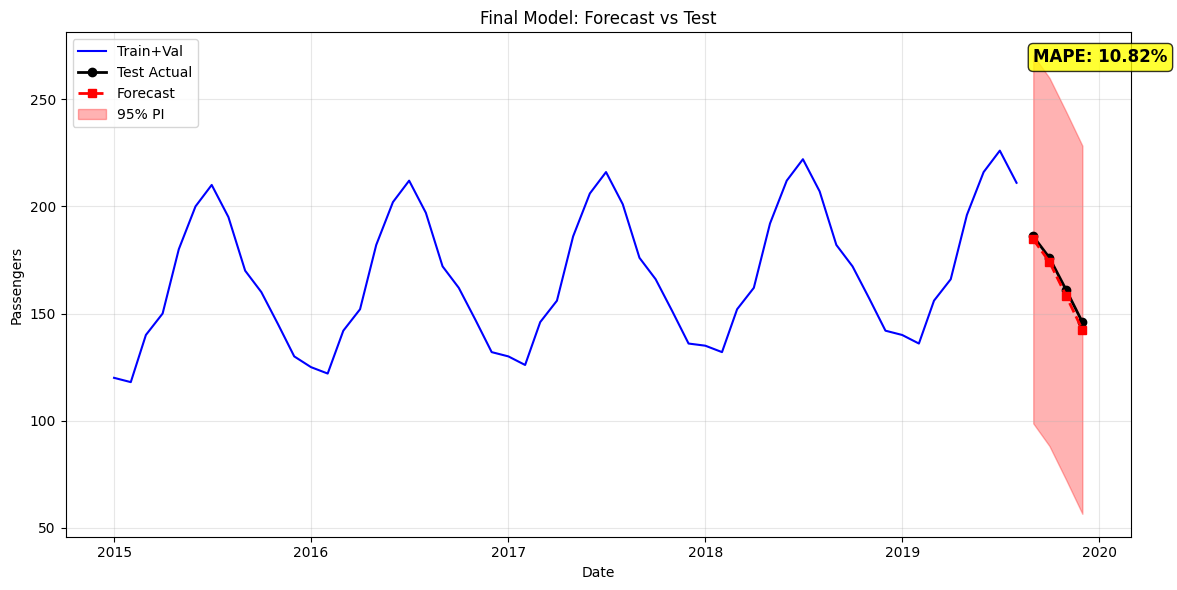

In [39]:
def final_model_evaluation(train_set, val_set, test_set):
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        train_val = pd.concat([train_set, val_set])

        model = ExponentialSmoothing(
        train_val,
        trend='add',
        seasonal='mul',
        seasonal_periods=12
        ).fit()

        forecast = model.forecast(steps=len(test_set))

        mape = np.mean(np.abs((test_set.values - forecast.values) / test_set.values)) * 100


        fitted = model.fittedvalues
        residuals = train_val.values - fitted.values  
        std_error = np.std(residuals[~np.isnan(residuals)])  # Remove NaN values

        lower_bound = forecast.values - 1.96 * std_error
        upper_bound = forecast.values + 1.96 * std_error

        print(f"MAPE: {mape:.2f}%")
        print(f"MAE: {np.mean(np.abs(test_set.values - forecast.values)):.2f}")
        print(f"STD ERROR: {std_error}")
        plt.figure(figsize=(12, 6))

        # Plot historical data
        plt.plot(train_val.index, train_val.values, 
                label='Train+Val', color='blue')

        # Plot test actual and forecast
        plt.plot(test_set.index, test_set.values, 
                'o-', label='Test Actual', color='black', linewidth=2)
        plt.plot(test_set.index, forecast.values, 
                's--', label='Forecast', color='red', linewidth=2)

        # Plot prediction intervals
        plt.fill_between(test_set.index, lower_bound, upper_bound,
                        alpha=0.3, color='red', label='95% PI')

        # Add MAPE annotation
        plt.text(test_set.index[0], plt.ylim()[1] * 0.95, 
                f'MAPE: {mape:.2f}%',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

        plt.title('Final Model: Forecast vs Test')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return model, forecast, mape

model, forecast, mape = final_model_evaluation(train, val, test)

---
